In [ ]:
"""
Filename: MorseOptimizedParameters.ipynb
Author: Alexay Mehra
Date: 2025-09-08
Description: Main file for testing, contains the following:
- Image of the Morse Potential to fit
- Code block to run the optimization function
- Visuals to compare synthesized time evolution with true time evolution
"""

In [7]:
# Imports

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from qutip import wigner, Qobj, displace, basis

from constants import time, mass, diss_energy, width_param, equib_length, omega, chi, hbar, morse_cap, N
from optimize_info import gate_seq, fidelity_loss, morse_to_optimize
from plotpot import plot_potential
from optimize_func import run_optimization, print_optimal_params

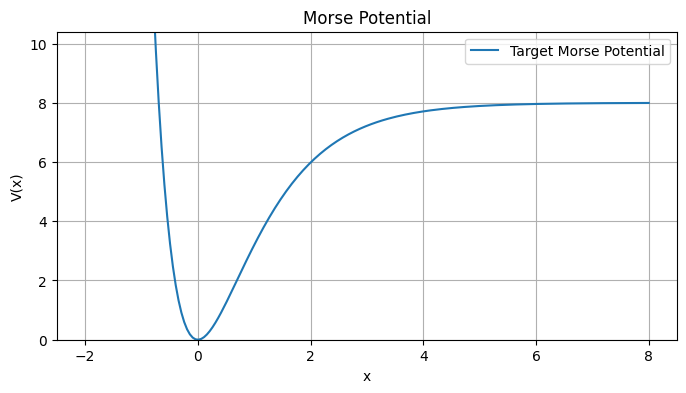

In [8]:
#Plot the Morse Potential
plot_potential()

In [13]:
# Run the Optimization

d = 2 # gate depth
optimal_params = run_optimization(d).x
print_optimal_params(optimal_params, d)

# The function value returned is the infidelity (lower is better)
infid = fidelity_loss(optimal_params, d, morse_to_optimize)
print("Exact Infidelity:", infid)

Optimization terminated successfully.
         Current function value: 0.752952
         Iterations: 51
         Function evaluations: 603
         Gradient evaluations: 67
Optimized Paramters
Gate 1:
  α     = -0.4991 + 0.0494j
  θ     = 3.1416
  φ     = 0.0087
------------------------------
Gate 2:
  α     = 0.2281 + 0.4468j
  θ     = -3.1416
  φ     = 0.0079
------------------------------
Exact Infidelity: 0.7529517748445047


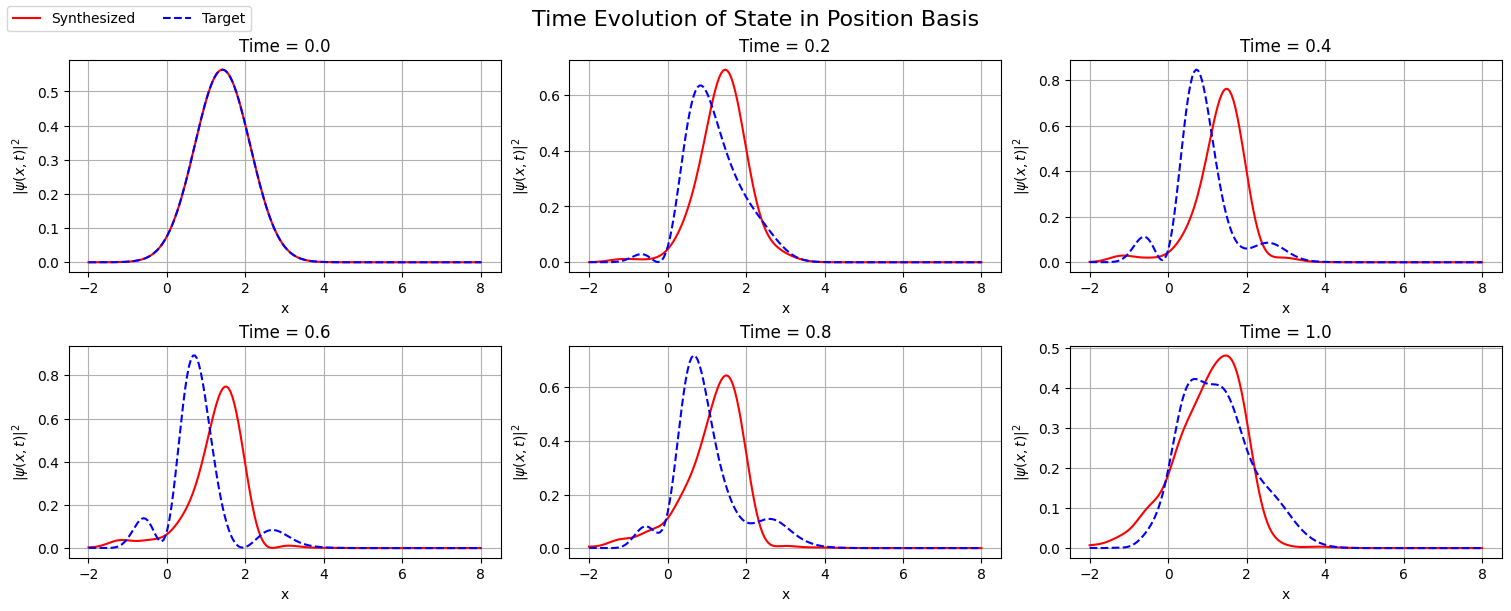

In [19]:
#Build the Synthesized Unitary
morse_generated = gate_seq(optimal_params, d)

# Function to Extract the Qumode Information from the Joint Qubit-Qumode State
def extract_qumode_info(hybrid_state, qubit_state_index, qumode_dim):
    """
    Args:
        hybrid_state: full state vector of shape (2 * qumode_dim,)
        qubit_state_index: 0 or 1
        qumode_dim: dimension of the qumode Fock space

    Returns:
        qumode_state: complex ndarray of shape (qumode_dim,)
    """
    assert hybrid_state.shape[0] == 2 * qumode_dim
    start = qubit_state_index * qumode_dim
    end = start + qumode_dim
    return hybrid_state[start:end]

# Function to Project to the Position Basis
def fock_basis_to_position(x, N, m=mass, hbar=hbar, omega=omega):
    """
    Returns T[i, n] = ⟨x_i | n⟩, i.e., harmonic oscillator wavefunction for n-th Fock state at position x_i
    """
    xi = np.sqrt(m * omega / hbar) * x
    prefactor = (m * omega / (np.pi * hbar))**0.25
    T = np.zeros((len(x), N), dtype=complex)

    for n in range(N):
        norm = 1 / np.sqrt(2**n * sp.special.factorial(n))
        Hn = sp.special.eval_hermite(n, xi)
        psi_n = prefactor * norm * np.exp(-0.5 * xi**2) * Hn
        T[:, n] = psi_n

    return T

# Extract the Hamiltonian from the Time Evolution
tgt_hamiltonian = (1j / time) * sp.linalg.logm(morse_to_optimize)
gen_hamiltonian = (1j / time) * sp.linalg.logm(morse_generated)

# End Time to be Visualized for the Wavefunctions
target_time = 1

# Parameters
x_var = np.linspace(-2, 8, 200)
topos = fock_basis_to_position(x_var, N)

# --- Choose Initial State ---

# Choose the Initial State for the Qubit
init_qubit_state = np.array([1, 0], dtype=complex)

# Choose the Initial State for the Qumode
    # Option 1: Fock state
#fock_state_index = 2
#init_qumode_state = np.zeros(N, dtype=complex)
#init_qumode_state[fock_state_index] = 1.0

    # Option 2: Coherent state
from qutip import coherent
alpha = 1.0 + 0.5j
init_qumode_state = coherent(N, alpha).full().flatten()

# Create the Initial State in the Full Qubit-Qumode Hilbert Space
init_state = np.kron(init_qubit_state, init_qumode_state)

# --- Time Steps ---
n_steps = 6
times = np.linspace(0, target_time, n_steps)

# --- Setup plot grid ---
cols = 3
rows = (n_steps + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 3 * rows), constrained_layout=True)
axes = axes.flatten()

# --- Loop through time evolution ---
for i, t in enumerate(times):
    ax = axes[i]

    # Evolve under synthesized
    U_gen_t = sp.linalg.expm(-1j * gen_hamiltonian * t)
    psi_gen_t = U_gen_t @ init_state
    psi_gen = extract_qumode_info(psi_gen_t, 0, N)
    psi_gen_x = topos @ psi_gen

    # Evolve under true
    U_tgt_t = sp.linalg.expm(-1j * tgt_hamiltonian * t)
    psi_tgt_t = U_tgt_t @ init_state
    psi_tgt = extract_qumode_info(psi_tgt_t, 0, N)
    psi_tgt_x = topos @ psi_tgt

    # Plot
    ax.plot(x_var, np.abs(psi_gen_x)**2, label='Synthesized', color='red')
    ax.plot(x_var, np.abs(psi_tgt_x)**2, label='Target', color='blue', linestyle='--')
    ax.set_title(f'Time = {round(t, 2)}')
    ax.set_xlabel('x')
    ax.set_ylabel(r'$|\psi(x,t)|^2$')
    ax.grid(True)

# Remove unused axes
for j in range(len(times), len(axes)):
    fig.delaxes(axes[j])

# Shared legend and title
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=2, fontsize='medium')
plt.suptitle(f'Time Evolution of State in Position Basis', fontsize=16)
plt.show()


Fidelity at t = 0.00: 1.000000
Fidelity at t = 0.17: 0.882281
Fidelity at t = 0.33: 0.649921
Fidelity at t = 0.50: 0.502528
Fidelity at t = 0.67: 0.516250
Fidelity at t = 0.83: 0.605786
Fidelity at t = 1.00: 0.644355


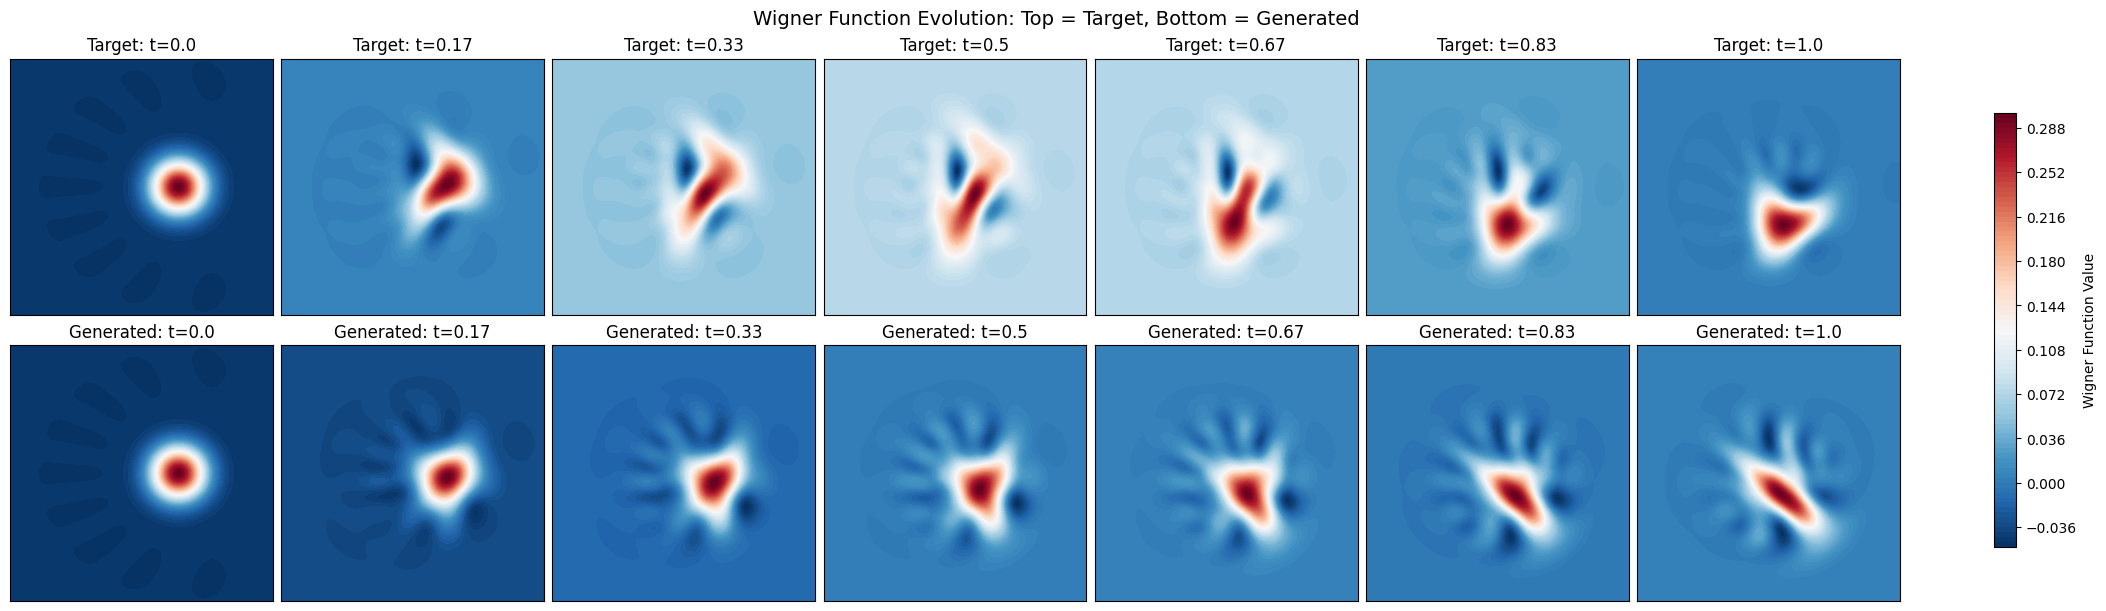

In [20]:
# Visualization for the Evolution of the Wigner Function Over Time

# Extract the Hamiltonian from the Time Evolution
target_hamiltonian = (1j / time) * sp.linalg.logm(morse_to_optimize)
generated_hamiltonian = (1j / time) * sp.linalg.logm(morse_generated)

# Choose the Number of Steps and Final Time to Visualize
steps = 6
time_and_extra = 1
time_step = time_and_extra / steps

# Define phase space grid
xvec = np.linspace(-5, 5, 200)

# --- Choose Initial State ---

# Choose the Initial State for the Qubit
wig_init_qubit_state = np.array([1, 0], dtype=complex)

# Choose the Initial State for the Qumode
    # Option 1: Fock state
# wig_fock_state_index = 2
# wig_init_qumode_state = np.zeros(N, dtype=complex)
# wig_init_qumode_state[fock_state_index] = 1.0

    # Option 2: Coherent state
from qutip import coherent
coherent_alpha = 1.0
wig_init_qumode_state = coherent(N, coherent_alpha).full().flatten()

# Create the Initial State in the Full Qubit-Qumode Hilbert Space
init_matrix = np.kron(wig_init_qubit_state, wig_init_qumode_state)

fig, axes = plt.subplots(2, steps+1, figsize=(3 * (steps+1), 6), constrained_layout=True)
fig.suptitle('Wigner Function Evolution: Top = Target, Bottom = Generated', fontsize=14)

for i in range(steps+1):
    t = i * time_step
    U_gen_t_wig = sp.linalg.expm(-1j * generated_hamiltonian * t)
    U_tgt_t_wig = sp.linalg.expm(-1j * target_hamiltonian * t)

    step_state_generated = U_gen_t_wig @ init_matrix
    step_state_target = U_tgt_t_wig @ init_matrix

    # Calculate Fidelity at Each Step
    fidelity = np.abs(np.vdot(step_state_generated, step_state_target))**2
    print(f"Fidelity at t = {t:.2f}: {fidelity:.6f}")

    qumode_generated = extract_qumode_info(step_state_generated, qubit_state_index=0, qumode_dim=N)
    qumode_target = extract_qumode_info(step_state_target, qubit_state_index=0, qumode_dim=N)

    # Convert to Qobj
    step_qobj_generated = Qobj(qumode_generated, dims=[N, [1]])
    step_qobj_target = Qobj(qumode_target, dims=[N, [1]])

    # Compute Wigner functions
    W_gen = wigner(step_qobj_generated, xvec, xvec)
    W_tar = wigner(step_qobj_target, xvec, xvec)

    # Top row: target
    ax_tar = axes[0, i]
    im1 = ax_tar.contourf(xvec, xvec, W_tar, 100, cmap='RdBu_r')
    ax_tar.set_title(f'Target: t={round(i*time_step, 2)}')
    ax_tar.set_xticks([])
    ax_tar.set_yticks([])

    # Bottom row: generated
    ax_gen = axes[1, i]
    im2 = ax_gen.contourf(xvec, xvec, W_gen, 100, cmap='RdBu_r')
    ax_gen.set_title(f'Generated: t={round(i*time_step, 2)}')
    ax_gen.set_xticks([])
    ax_gen.set_yticks([])

# Add single shared colorbar using a separate figure method
fig.colorbar(im1, ax=axes, location='right', shrink=0.8, label='Wigner Function Value')

plt.show()

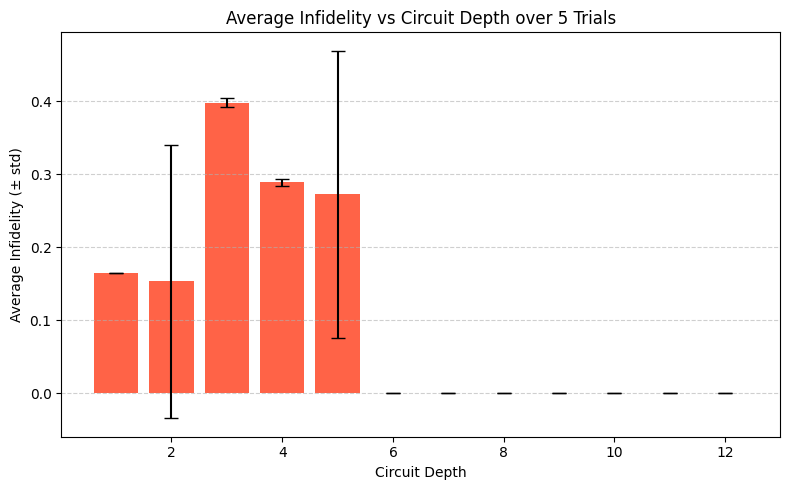

Depth 1: mean = 0.164113, std = 0.000000
Depth 2: mean = 0.152975, std = 0.187318
Depth 3: mean = 0.397859, std = 0.006409
Depth 4: mean = 0.288702, std = 0.004851
Depth 5: mean = 0.272208, std = 0.196632
Depth 6: mean = 0.000029, std = 0.000022
Depth 7: mean = 0.000010, std = 0.000006
Depth 8: mean = 0.000014, std = 0.000007
Depth 9: mean = 0.000004, std = 0.000002
Depth 10: mean = 0.000005, std = 0.000002
Depth 11: mean = 0.000005, std = 0.000004
Depth 12: mean = 0.000003, std = 0.000001


In [14]:
# Infidelity vs Gate Depth

min_depth = 1
max_depth = 12
depths = [x for x in range(min_depth, max_depth + 1)]
infidelities_mean = []
infidelities_std = []

n_trials = 5  # Number of optimization runs per depth

for depth in depths:
    num_params = depth * 4
    trial_infid = []

    for trial in range(n_trials):
        init_guess = np.random.rand(num_params) * 0.1

        result = sp.optimize.minimize(
            fidelity_loss,
            init_guess,
            args=(depth, morse_to_optimize),
            method='BFGS',
            options={'disp': False}
        )

        params_optimized = result.x
        infid = fidelity_loss(params_optimized, depth, morse_to_optimize)
        trial_infid.append(infid)

    # Record average and std dev
    infidelities_mean.append(np.mean(trial_infid))
    infidelities_std.append(np.std(trial_infid))

# --- Plot with error bars ---
plt.figure(figsize=(8, 5))
plt.bar(depths, infidelities_mean, yerr=infidelities_std, capsize=5, color='tomato')
plt.xlabel('Circuit Depth')
plt.ylabel('Average Infidelity (± std)')
plt.title(f'Average Infidelity vs Circuit Depth over {n_trials} Trials')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Optional: print full data
for d, mean, std in zip(depths, infidelities_mean, infidelities_std):
    print(f"Depth {d}: mean = {mean:.6f}, std = {std:.6f}")